In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../Data/raw_analyst_ratings.csv/raw_analyst_ratings.csv")


#### Descriptive Statistics
1.  Obtain basic statistics for textual lengths (like headline length).
    * Calculate the number of characters or words in each news headline.

    * Analyze the distribution (e.g., average, median, max, min headline lengths).

    Why It’s Important:
    *   Signal strength: Longer headlines might carry more detailed or significant information.

    * Noise detection: Extremely short or long headlines could be outliers or irrelevant.

    * Feature engineering: Headline length itself can be used as a numerical feature in your ML model. For example, urgent news might have short punchy headlines (“Apple crashes 12%”) which correlate with big stock moves.


2. Count the number of articles per publisher to identify which publishers are most active.
    Why It’s Important:
    * Publisher bias: Some publishers may report more positively or negatively about certain stocks.

    * Data reliability: Publishers with too few articles may not provide enough data to be useful.

    * Weighting: You may want to give more weight to more reputable or more frequently publishing sources.

    * Source pattern recognition: Identify which publishers tend to write before significant stock movements.

3. Analyze the publication dates to see trends over time, such as increased news frequency on particular days or during specific events.
    Why It’s Important:
    * Market reaction timing: You may find that stock prices respond differently depending on when news is published (e.g., weekday vs weekend).

    * Volume signal: A spike in articles could indicate a significant event worth modeling.

    * Seasonality: Some companies or sectors might have regular cycles of news (e.g., quarterly earnings).

In [3]:
df['headline_length']=df['headline'].apply(lambda x: len(str(x)))
print(df['headline_length'].describe())

count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


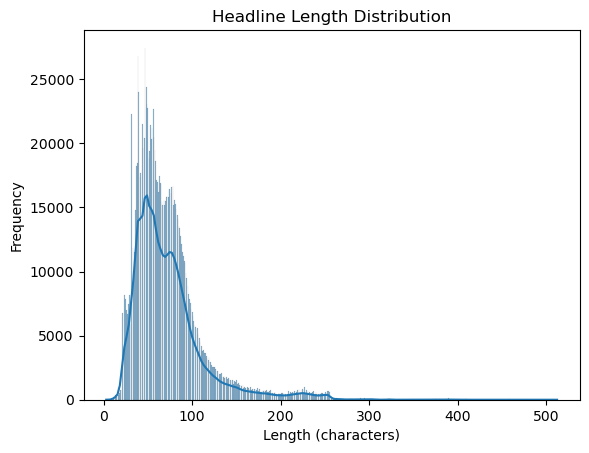

In [4]:

sns.histplot(df['headline_length'], kde=True)
plt.title("Headline Length Distribution")
plt.xlabel("Length (characters)")
plt.ylabel("Frequency")
plt.show()

publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


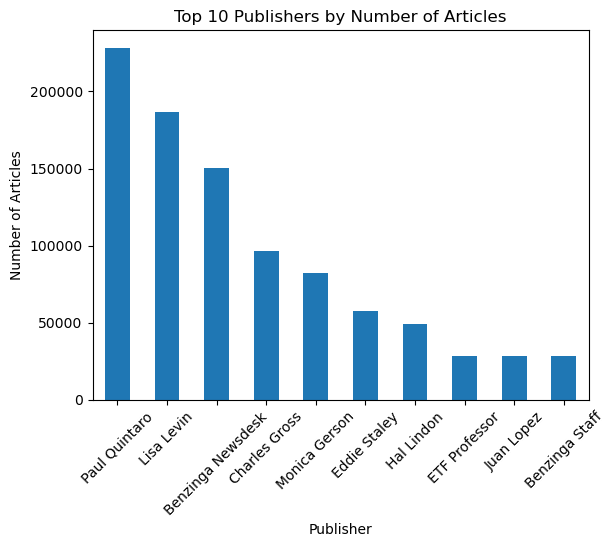

In [5]:
publisher_counts = df['publisher'].value_counts()

print(publisher_counts.head(10)) 

publisher_counts.head(10).plot(kind='bar')
plt.title("Top 10 Publishers by Number of Articles")
plt.xlabel("Publisher")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.show()
